In [15]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r'E:\programming\dataset\Into_to_statstical_learning\Heart.csv',index_col = 0)
print(data.shape)
data.head()

(303, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [3]:
data.dropna(inplace = True)

In [4]:
data['AHD'].value_counts()

No     160
Yes    137
Name: AHD, dtype: int64

In [5]:
# encoding the categorical variables
data['ChestPain'].value_counts()

asymptomatic    142
nonanginal       83
nontypical       49
typical          23
Name: ChestPain, dtype: int64

In [6]:
data['Thal'].value_counts()

normal        164
reversable    115
fixed          18
Name: Thal, dtype: int64

The below code taken from - https://github.com/hardikkamboj/Code/blob/master/my_encoder/my_encoder.py

In [7]:
# for encoding

from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class Myencoder(BaseEstimator, TransformerMixin):
   
    def __init__(self,drop = 'first',sparse=False):
        self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
        self.drop = True if drop == 'first' else False
        self.features_to_encode = []
        self.columns = []
    
    def fit(self,X_train,features_to_encode):
        
        data = X_train.copy()
        self.features_to_encode = features_to_encode
        data_to_encode = data[self.features_to_encode]
        self.columns = pd.get_dummies(data_to_encode,drop_first = self.drop).columns
        self.encoder.fit(data_to_encode)
        return self.encoder
    
    def transform(self,X_test):
        
        data = X_test.copy()
        data.reset_index(drop = True,inplace =True)
        data_to_encode = data[self.features_to_encode]
        data_left = data.drop(self.features_to_encode,axis = 1)
        
        data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
        
        return pd.concat([data_left,data_encoded],axis = 1)

In [8]:
my_enc = Myencoder(drop = None)
my_enc.fit(data,['ChestPain','Thal'])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [9]:
data = my_enc.transform(data)

In [10]:
data.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,No,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,Yes,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,Yes,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37,1,130,250,0,0,187,0,3.5,3,0.0,No,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,No,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
data['AHD'] = data['AHD'].map({'Yes':1,'No':0})

In [12]:
data.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [16]:
# splitting the X and y data
X = data.drop('AHD',axis = 1)
y = data['AHD']

In [31]:
score_dict = {}
for tree_size in np.arange(1,21):
    cls = DecisionTreeClassifier(max_depth=tree_size)
    score_dict[tree_size] = np.mean(cross_val_score(cls,X,y,cv=10))

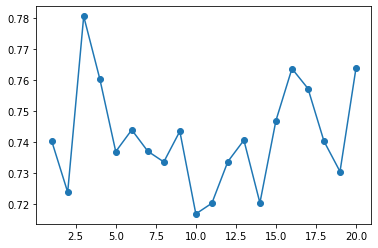

In [23]:
plt.plot(list(score_dict.keys()),list(score_dict.values()),marker = 'o')
plt.xlable('Tree Max Depth')
plt.ylabel('10 CV Score')

In [24]:
# the best performane is when max tree deoth is 10
cls = DecisionTreeClassifier(max_depth=10)
cls.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

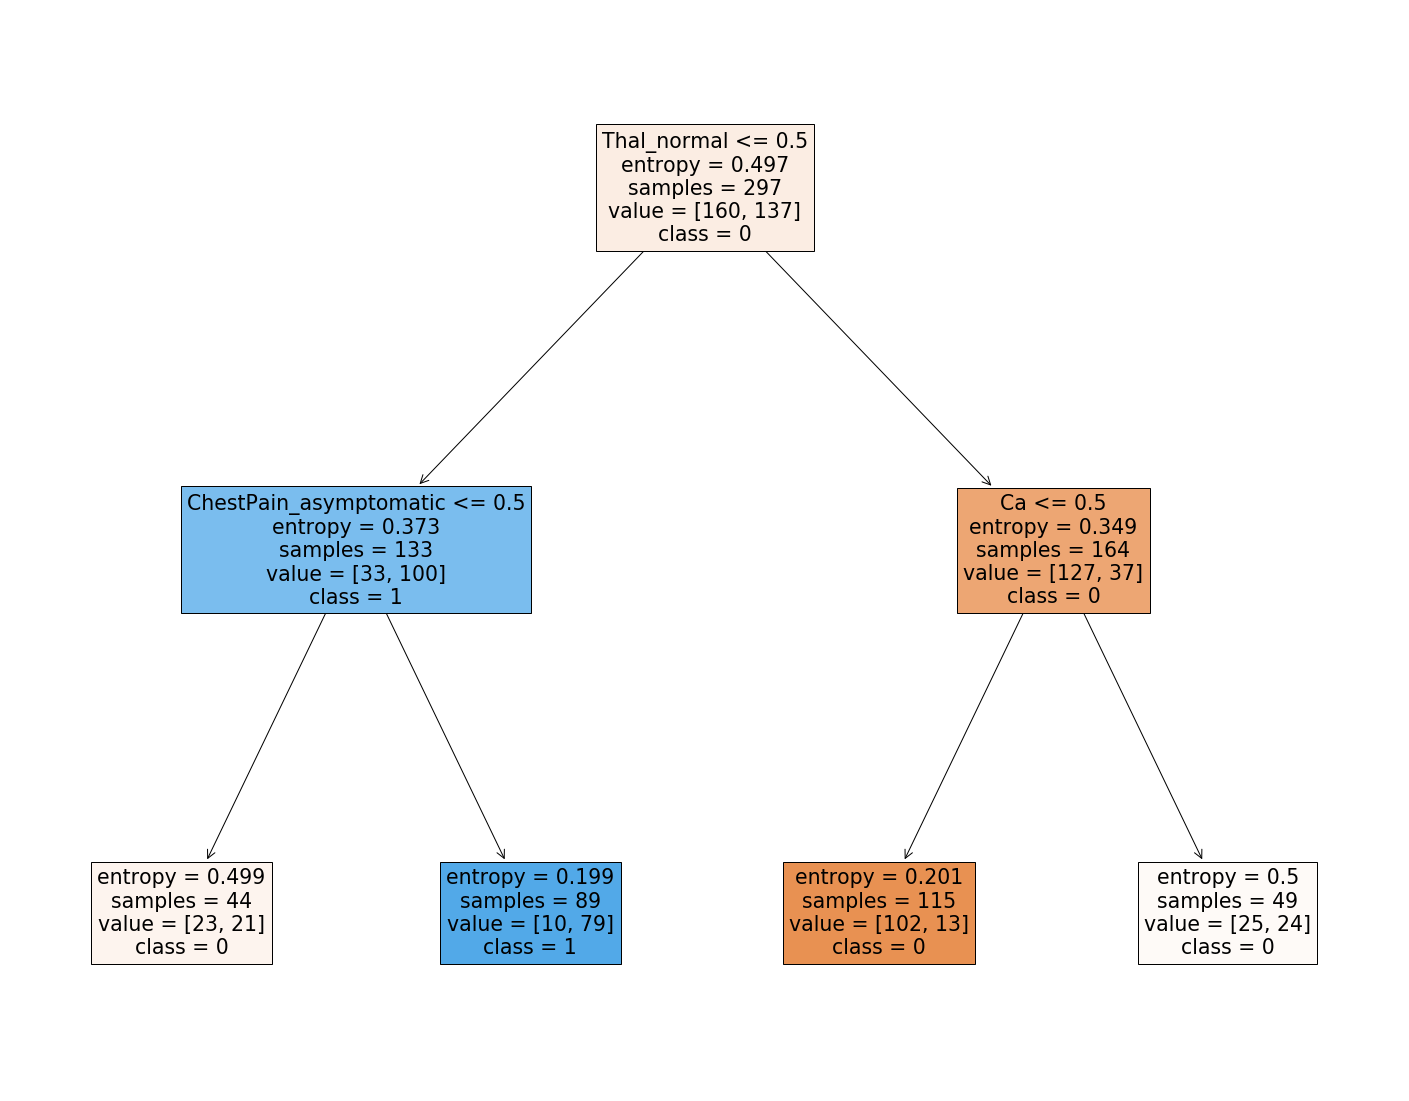

In [34]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(cls, 
                   feature_names=X.columns,  
                   class_names=['0','1'],
                   filled=True)

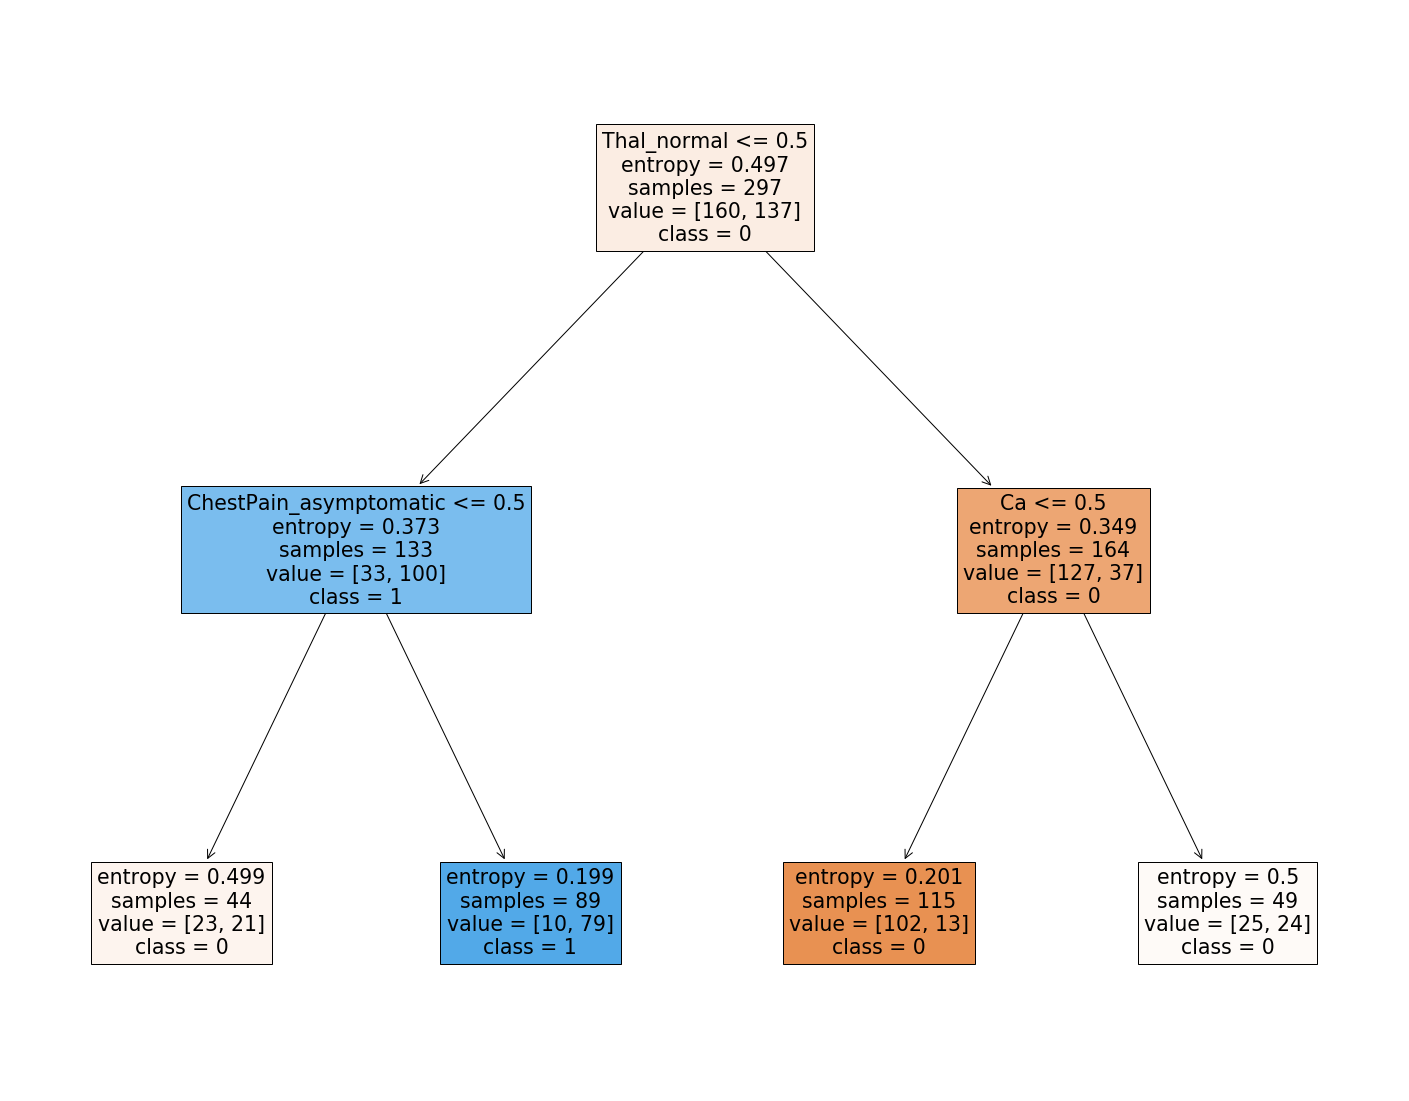

In [35]:
# the best performane is when max tree deoth is 10
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(X,y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(cls, 
                   feature_names=X.columns,  
                   class_names=['0','1'],
                   filled=True)